```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016, 2017, 2018  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [8]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [9]:
%cuda_context_handler gpu_ctx

In [10]:
#Create output directory for images
imgdir='images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_2023_03_02-10_35_36


In [11]:
# Set initial conditions common to all simulators
dt = 1
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": 200, "ny": 400,
"dx": 100.0, "dy": 100.0,
"dt": dt,
"g": 9.81,
"f": 0.0012,
"coriolis_beta": 0, #1.0e-6,
"r": 0.0
}

In [12]:
# Choose to make animations or static plot of final state
makeAnimation = False

In [13]:

def sim_animation(sim, T, makeAnimation=True):
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 8))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-0.01, vmax=0.01, extent=domain_extent)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-0.05, vmax=0.05, extent=domain_extent)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(10.0)
        else:
            t = 0.0
        eta1, u1, v1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        fig.sca(ax_u)
        sp_u.set_data(u1)
        
        fig.sca(ax_v)
        sp_v.set_data(v1)
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    if makeAnimation:
        print("Making animation")
        #Matplotlib for creating an animation
        anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
        plt.close(fig)
        return anim
    else:
        print("Plotting static figure")
        for i in range(T):
            animate(i)
            

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\KP07.py:170: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


Plotting static figure
..................................................

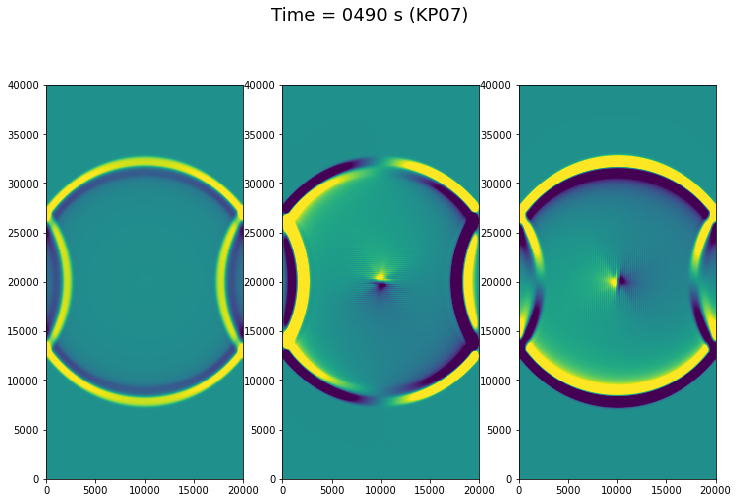

In [18]:
from importlib import reload
reload(KP07)

ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
sim_args["dt"] = 1.0
#Initialize simulator
ctcs_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "use_rk2": True}
sim = KP07.KP07(**ctcs_args, **sim_args, flux_delimiter=1.0)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)

15.707964
15.707964
1.0


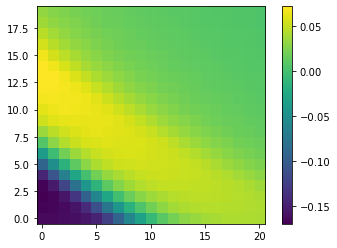

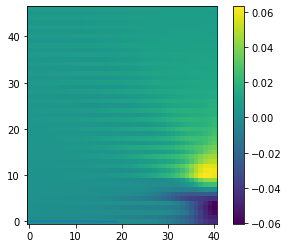

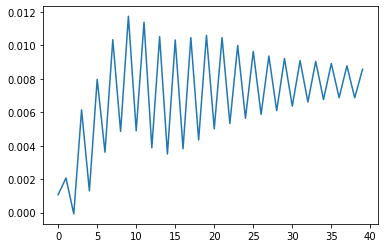

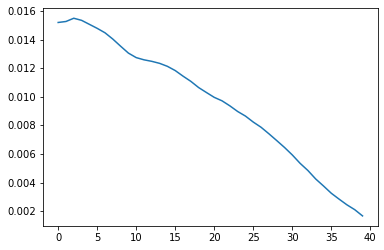

In [19]:
print(np.sum(eta0[2:-2, 2:-2]))
eta, hu, hv = sim.download(interior_domain_only=False)
print(np.sum(eta[2:-2, 2:-2]))
print(sim.dt)


plt.imshow(hu[102:122, 32:53], origin="lower")
plt.colorbar()

plt.figure()
plt.plot(hu[102:122, 42])

plt.imshow(hu[195:242, 62:103], origin="lower")
plt.colorbar()

plt.figure()
plt.plot(hu[202:242, 82])
plt.figure()
plt.plot(hv[202:242, 82])

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:220: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


Plotting static figure
..................................................

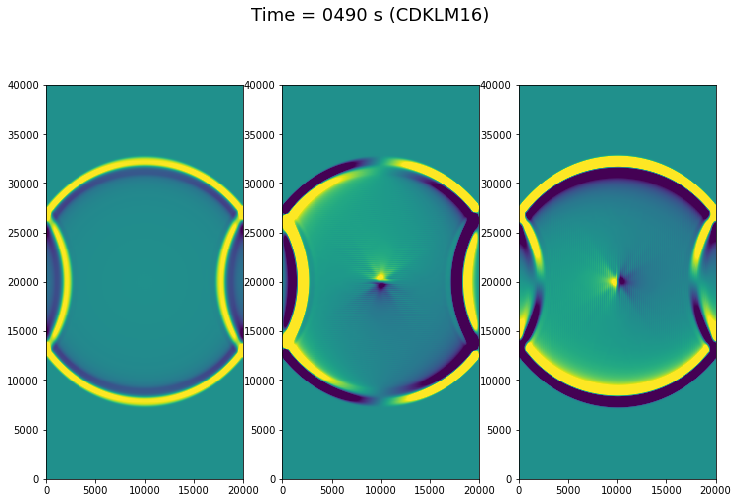

In [20]:
from importlib import reload

reload(CDKLM16)

ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * 60.0
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)

#Create bump in to lower left of domain for testing
addCentralBump(eta0, sim_args["nx"], sim_args["ny"], sim_args["dx"], sim_args["dy"], ghosts)
#eta0[42:62, 42:62] = eta0[92:112, 42:62]
#eta0[142:162, 42:62] = eta0[92:112, 42:62]
sim_args["dt"] = dt
#old_f = sim_args["f"]
#sim_args["f"] = 0.0012

#Initialize simulator
ctcs_args = {"H": H, "eta0": eta0, "hu0": u0, "hv0": v0, "rk_order": 2}
sim = CDKLM16.CDKLM16(**ctcs_args, **sim_args, 
                        flux_delimiter=1.0, theta = 1.5)

#Run a simulation and plot it
sim_animation(sim, T=50, makeAnimation=makeAnimation)

15.707964
15.707965
1


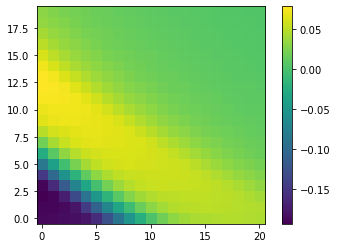

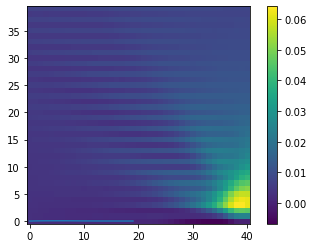

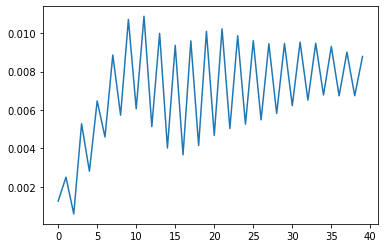

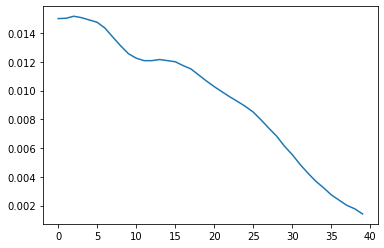

In [21]:
print(np.sum(eta0[2:-2, 2:-2]))
eta, hu, hv = sim.download(interior_domain_only=False)
print(np.sum(eta[2:-2, 2:-2]))
print(sim.dt)


plt.imshow(hu[102:122, 32:53], origin="lower")
plt.colorbar()

plt.figure()
plt.plot(hu[102:122, 42])

plt.imshow(hu[202:242, 62:103], origin="lower")
plt.colorbar()

plt.figure()
plt.plot(hu[202:242, 82])
plt.figure()
plt.plot(hv[202:242, 82])

Plotting static figure


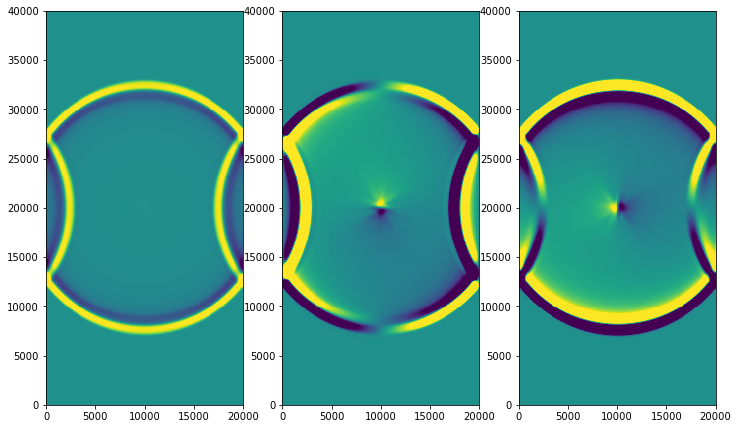

In [27]:
# Use the standard upwind results from before and step a bit with central upwind

oscillating_args = {"H": H, "eta0": eta, "hu0": hu, "hv0": hv, "rk_order": 2}
sim = CDKLM16.CDKLM16(**oscillating_args, **sim_args, 
                        flux_delimiter=0.0)
sim.step(sim.dt*10)
sim_animation(sim, T=0, makeAnimation=makeAnimation)

15.707964
15.707965
1


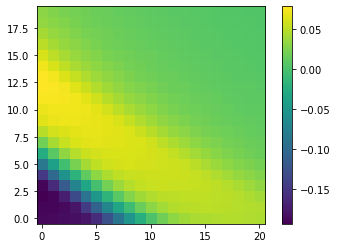

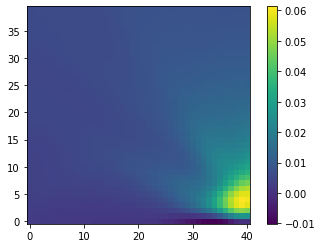

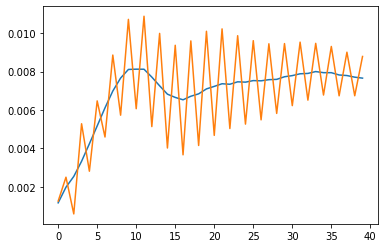

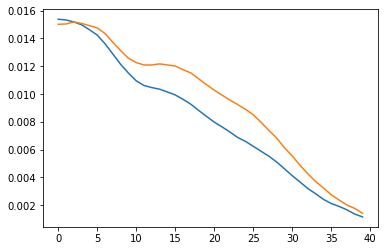

In [31]:
print(np.sum(eta0[2:-2, 2:-2]))
eta_cu, hu_cu, hv_cu = sim.download(interior_domain_only=False)
print(np.sum(eta[2:-2, 2:-2]))
print(sim.dt)


plt.imshow(hu[102:122, 32:53], origin="lower")
plt.colorbar()

plt.figure()
#plt.plot(hu[102:122, 42])

plt.imshow(hu_cu[202:242, 62:103], origin="lower")
plt.colorbar()

plt.figure()
plt.plot(hu_cu[202:242, 82])
plt.plot(hu[202:242, 82])
plt.figure()
plt.plot(hv_cu[202:242, 82])
plt.plot(hv[202:242, 82])

In [ ]:
eta_0, hu_0, hv_0 = sim.download(interior_domain_only=True)